In [6]:
import base64
import io
import pickle
import numpy as np
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
    raise RuntimeError('Torch versions lower than 1.5.0 not supported')
    
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

ModuleNotFoundError: No module named 'torch'

In [2]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cuda


c:\Users\FishCat\.conda\envs\python-env\Lib\site-packages\torch\__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


In [3]:
def torch_mod(x):
    return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
    return torch_mod(x+np.pi) - np.pi

In [4]:
def grab(var):
    return var.detach().cpu().numpy()

In [5]:
from IPython.display import display
def init_live_plot(dpi=125, figsize=(8,4)):
    fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era*N_epoch)
    plt.ylim(0, 1)
    ess_line = plt.plot([0],[0], alpha=0.5) # dummy
    plt.grid(False)
    plt.ylabel('ESS')
    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
    plt.grid(False)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    display_id = display(fig, display_id=True)
    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
    )
def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window
def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y)))
    Y = history['loss']
    Y = moving_average(Y, window=15)
    loss_line[0].set_ydata(np.array(Y))
    loss_line[0].set_xdata(np.arange(len(Y)))
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

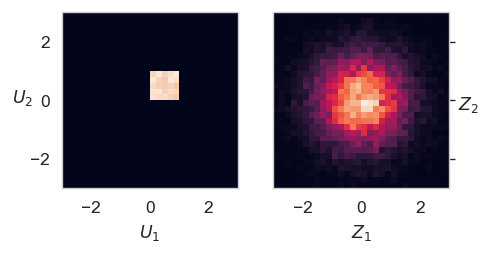

In [6]:
batch_size = 2**14
u = np.random.random(size=(batch_size, 2))
z = np.sqrt(-2*np.log(u[:,0]))[:,np.newaxis] * np.stack(
    (np.cos(2*np.pi*u[:,1]), np.sin(2*np.pi*u[:,1])), axis=-1)

fig, ax = plt.subplots(1,2, dpi=125, figsize=(4,2))
for a in ax:
    a.set_xticks([-2, 0, 2])
    a.set_yticks([-2, 0, 2])
    a.set_aspect('equal')
ax[0].hist2d(u[:,0], u[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[0].set_xlabel(r"$U_1$")
ax[0].set_ylabel(r"$U_2$", rotation=0, y=.46)
ax[1].hist2d(z[:,0], z[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[1].set_yticklabels([])
ax[1].set_xlabel(r"$Z_1$")
ax[1].set_ylabel(r"$Z_2$", rotation=0, y=.53)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
plt.show()

In [7]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(
            torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)
    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)


In [8]:
normal_prior = SimpleNormal(torch.zeros((3,4,5)), torch.ones((3,4,5)))
z = normal_prior.sample_n(17)
print(f'z.shape = {z.shape}')
print(f'log r(z) = {grab(normal_prior.log_prob(z))}')

z.shape = torch.Size([17, 3, 4, 5])
log r(z) = [-93.48385  -74.6288   -80.785965 -90.19418  -91.81434  -85.82274
 -80.313736 -80.35843  -82.4436   -93.71699  -83.57634  -98.73154
 -87.05475  -84.83868  -84.23931  -87.06278  -79.62145 ]


In [9]:
class SimpleCouplingLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
        torch.nn.Linear(1, 8),
        torch.nn.ReLU(),
        torch.nn.Linear(8, 8),
        torch.nn.ReLU(),
        torch.nn.Linear(8, 1),
        torch.nn.Tanh()
        )
    def forward(self, x):
        x1, x2 = x[:,0], x[:,1]
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        fx1 = torch.exp(s) * x1
        fx2 = x2
        logJ = s
        return torch.stack((fx1, fx2), dim=-1), logJ
    def reverse(self, fx):
        fx1, fx2 = fx[:,0], fx[:,1]
        x2 = fx2
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        logJ = -s
        x1 = torch.exp(-s) * fx1
        return torch.stack((x1, x2), dim=-1), logJ

coupling_layer = SimpleCouplingLayer()

# init weights in a way that gives interesting behavior without training
def set_weights(m):
    if hasattr(m, 'weight') and m.weight is not None:
        torch.nn.init.normal_(m.weight, mean=1, std=2)
    if hasattr(m, 'bias') and m.bias is not None:
        m.bias.data.fill_(-1)
torch.manual_seed(1234)
coupling_layer.s.apply(set_weights);

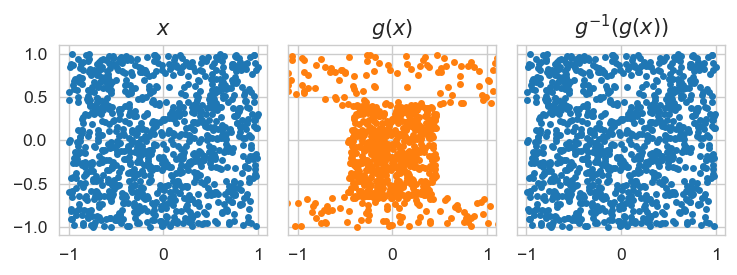

In [10]:
batch_size = 1024
np_x = (2*np.random.random(size=(batch_size, 2)) - 1).astype(float_dtype)
x = torch.from_numpy(np_x).to(torch_device)

gx, fwd_logJ = coupling_layer.forward(x)
xp, bwd_logJ = coupling_layer.reverse(gx)

fig, ax = plt.subplots(1,3, dpi=125, figsize=(6,2.3), sharex=True, sharey=True)
np_gx, np_xp = grab(gx), grab(xp)
for a in ax:
    a.set_xlim(-1.1,1.1)
    a.set_ylim(-1.1,1.1)
ax[0].scatter(np_x[:,0], np_x[:,1], marker='.')
ax[0].set_title(r'$x$')
ax[1].scatter(np_gx[:,0], np_gx[:,1], marker='.', color='tab:orange')
ax[1].set_title(r'$g(x)$')
ax[2].scatter(np_xp[:,0], np_xp[:,1], marker='.')
ax[2].set_title(r"$g^{-1}(g(x))$")
fig.set_tight_layout(True)
plt.show()


In [11]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size):
    x = prior.sample_n(batch_size)
    logq = prior.log_prob(x)
    for layer in coupling_layers:
        x, logJ = layer.forward(x)
        logq = logq - logJ
    return x, logq

In [12]:
L = 8
lattice_shape = (L,L)
phi_ex1 = np.random.normal(size=lattice_shape).astype(float_dtype)
phi_ex2 = np.random.normal(size=lattice_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((phi_ex1, phi_ex2), axis=0)).to(torch_device)


In [13]:
class ScalarPhi4Action:
    def __init__(self, M2, lam):
        self.M2 = M2
        self.lam = lam
    def __call__(self, cfgs):
        # potential term
        action_density = self.M2*cfgs**2 + self.lam*cfgs**4
        # kinetic term (discrete Laplacian)
        Nd = len(cfgs.shape)-1
        dims = range(1,Nd+1)
        for mu in dims:
            action_density += 2*cfgs**2
            action_density -= cfgs*torch.roll(cfgs, -1, mu)
            action_density -= cfgs*torch.roll(cfgs, 1, mu)
        return torch.sum(action_density, dim=tuple(dims))
print("Actions for example configs:", ScalarPhi4Action(M2=1.0, lam=1.0)(cfgs))

Actions for example configs: tensor([463.1267, 466.0899])


In [14]:
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

In [15]:
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

z.shape = (1024, 8, 8)


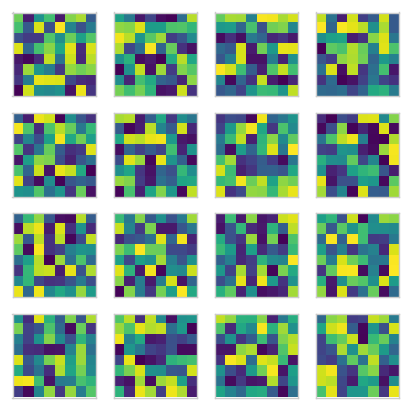

In [16]:
torch_z = prior.sample_n(1024)
z = grab(torch_z)
print(f'z.shape = {z.shape}')
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()


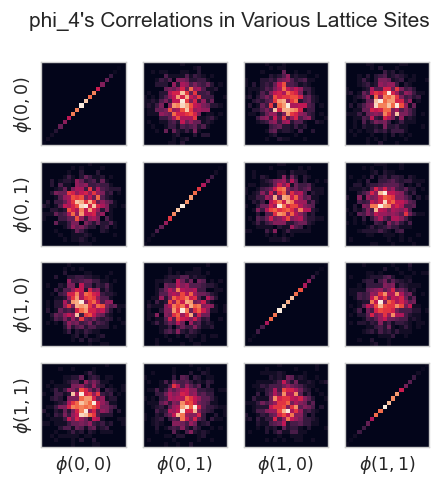

In [17]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for x1 in range(2):
    for y1 in range(2):
        i1 = x1*2 + y1
        for x2 in range(2):
            for y2 in range(2):
                i2 = x2*2 + y2
                ax[i1,i2].hist2d(z[:,x1,y1], z[:,x2,y2], range=[[-3,3],[-3,3]], bins=20)
                ax[i1,i2].set_xticks([])
                ax[i1,i2].set_yticks([])
                if i1 == 3:
                    ax[i1,i2].set_xlabel(rf'$\phi({x2},{y2})$')
                if i2 == 0:
                    ax[i1,i2].set_ylabel(rf'$\phi({x1},{y1})$')
fig.suptitle("phi_4's Correlations in Various Lattice Sites")
plt.show()

slope 1 linear regression S = -logr + 1415.8898


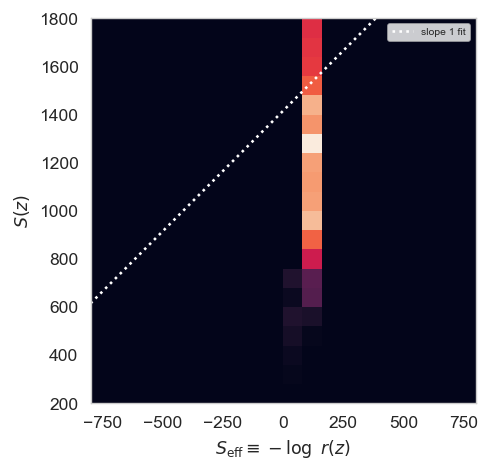

In [18]:
S_eff = -grab(prior.log_prob(torch_z))
S = grab(phi4_action(torch_z))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = -logr + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[-800, 800], [200,1800]])
xs = np.linspace(-800, 800, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
ax.set_xlabel(r'$S_{\mathrm{eff}} \equiv -\log~r(z)$')
ax.set_ylabel(r'$S(z)$')
ax.set_aspect('equal')
plt.legend(prop={'size': 6})
plt.show()

In [19]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker.to(torch_device)
print("For example this is the mask for an 8x8 configuration:\n",
    make_checker_mask(lattice_shape, 0))


For example this is the mask for an 8x8 configuration:
 tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)


In [20]:
class AffineCoupling(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_parity):
        super().__init__()
        self.mask = make_checker_mask(mask_shape, mask_parity)
        self.net = net
    def forward(self, x):
        x_frozen = self.mask * x
        x_active = (1 - self.mask) * x
        net_out = self.net(x_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        fx = (1 - self.mask) * t + x_active * torch.exp(s) + x_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))
        return fx, logJ
    def reverse(self, fx):
        fx_frozen = self.mask * fx
        fx_active = (1 - self.mask) * fx
        net_out = self.net(fx_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        x = (fx_active - (1 - self.mask) * t) * torch.exp(-s) + fx_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask)*(-s), dim=tuple(axes))
        return x, logJ

In [21]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_final_tanh):
    sizes = [in_channels] + hidden_sizes + [out_channels]
    assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0')
    assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0'
    padding_size = (kernel_size // 2)
    net = []
    for i in range(len(sizes) - 1):
        net.append(torch.nn.Conv2d(
            sizes[i], sizes[i+1], kernel_size, padding=padding_size,
            stride=1, padding_mode='circular'))
        if i != len(sizes) - 2:
            net.append(torch.nn.LeakyReLU())
        else:
            if use_final_tanh:
                net.append(torch.nn.Tanh())
    return torch.nn.Sequential(*net)

In [22]:
def make_phi4_affine_layers(*, n_layers, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
        parity = i % 2
        net = make_conv_net(
            in_channels=1, out_channels=2, hidden_sizes=hidden_sizes,
            kernel_size=kernel_size, use_final_tanh=True)
        coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity)
        layers.append(coupling)
    return torch.nn.ModuleList(layers)

In [23]:
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(
    lattice_shape=lattice_shape, n_layers=n_layers,
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

In [24]:
def calc_dkl(logp, logq):
    return (logq - logp).mean() # reverse KL, assuming samples from q

In [25]:
def train_step(model, action, loss_fn, optimizer, metrics):
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()
    x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
    logp = -action(x)
    loss = calc_dkl(logp, logq)
    loss.backward()
    optimizer.step()
    metrics['loss'].append(grab(loss))
    metrics['logp'].append(grab(logp))
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab( compute_ess(logp, logq) ))


In [26]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg

In [27]:
def print_metrics(history, avg_last_N_epochs):
    print(f'== Era {era} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key} {avgd:g}')

In [28]:
use_pretrained = False

In [29]:
# Lattice Theory
L = 8
lattice_shape = (L,L)
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)
# Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(lattice_shape=lattice_shape, n_layers=n_layers,
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}
# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

In [30]:
if use_pretrained:
    print('Loading pre-trained model')
    phi4_trained_weights = torch.load(io.BytesIO(base64.b64decode(b"""
<snipped base64 blob>
""".strip())), map_location=torch.device('cpu'))
    model['layers'].load_state_dict(phi4_trained_weights)
    if torch_device == 'cuda':
        model['layers'].cuda()
else:
    print('Skipping pre-trained model')

Skipping pre-trained model


In [31]:
N_era = 25
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1
history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

: 

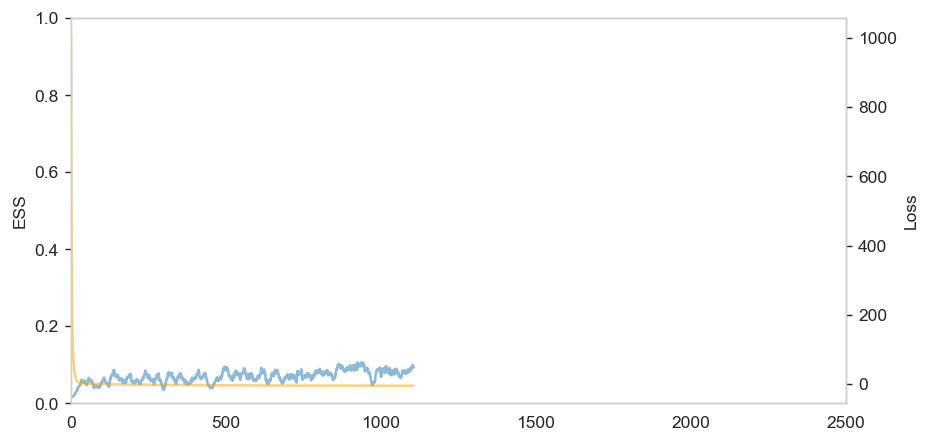

== Era 0 | Epoch 0 metrics ==
	loss 6307.77
	logp -6412.04
	logq -104.267
	ess 0.015625
== Era 1 | Epoch 0 metrics ==
	loss 91.2494
	logp -112.253
	logq -21.0037
	ess 0.0425999
== Era 2 | Epoch 0 metrics ==
	loss -1.29895
	logp -12.3019
	logq -13.6008
	ess 0.0631623
== Era 3 | Epoch 0 metrics ==
	loss -2.56888
	logp -13.1273
	logq -15.6962
	ess 0.0623096
== Era 4 | Epoch 0 metrics ==
	loss -3.07196
	logp -12.7991
	logq -15.871
	ess 0.0606577
== Era 5 | Epoch 0 metrics ==
	loss -3.68227
	logp -12.5106
	logq -16.1929
	ess 0.0629708
== Era 6 | Epoch 0 metrics ==
	loss -4.16568
	logp -12.5937
	logq -16.7594
	ess 0.075104
== Era 7 | Epoch 0 metrics ==
	loss -4.54229
	logp -12.5882
	logq -17.1305
	ess 0.0686103
== Era 8 | Epoch 0 metrics ==
	loss -4.83541
	logp -12.5559
	logq -17.3913
	ess 0.0711384
== Era 9 | Epoch 0 metrics ==
	loss -4.91144
	logp -12.5298
	logq -17.4412
	ess 0.0826371
== Era 10 | Epoch 0 metrics ==
	loss -5.18434
	logp -12.3847
	logq -17.569
	ess 0.0865682
== Era 11 | Epo

In [32]:
if not use_pretrained:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
    live_plot = init_live_plot()
    for era in range(N_era):
        for epoch in range(N_epoch):
            train_step(model, phi4_action, calc_dkl, optimizer, history)
            if epoch % print_freq == 0:
                print_metrics(history, avg_last_N_epochs=print_freq)
            if epoch % plot_freq == 0:
                update_plots(history, **live_plot)
else:
    print('Skipping training')

In [301]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8'))
print('===')

Model weights blob:
===
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRmxvYXRTdG9yYWdlCnEFWAEAAAAwcQZYBgAAAGN1ZGE6MHEHS0h0cQhRSwAoSwhLAUsDSwN0cQkoSwlLCUsDSwF0cQqJaAApUnELdHEMUnENWAwAAAAwLm5ldC4wLmJpYXNxDmgDKChoBGgFWAEAAAAxcQ9YBgAAAGN1ZGE6MHEQSwh0cRFRSwBLCIVxEksBhXETiWgAKVJxFHRxFVJxFlgOAAAAMC5uZXQuMi53ZWlnaHRxF2gDKChoBGgFWAEAAAAycRhYBgAAAGN1ZGE6MHEZTUACdHEaUUsAKEsISwhLA0sDdHEbKEtISwlLA0sBdHEciWgAKVJxHXRxHlJxH1gMAAAAMC5uZXQuMi5iaWFzcSBoAygoaARoBVgBAAAAM3EhWAYAAABjdWRhOjBxIksIdHEjUUsASwiFcSRLAYVxJYloAClScSZ0cSdScShYDgAAADAubmV0LjQud2VpZ2h0cSloAygoaARoBVgBAAAANHEqWAYAAABjdWRhOjBxK0uQdHEsUUsAKEsCSwhLA0sDdHEtKEtISwlLA0sBdHEuiWgAKVJxL3RxMFJxMVgMAAAAMC5uZXQuNC5iaWFzcTJoAygoaARoBVgBAAAANXEzWAYAAABjdWRhOjBxNEsCdHE1UUsASwKFcTZLAYVxN4loAClScTh0cTlScTpYDgAAADEubmV0LjAud2VpZ2h0cTtoAygoaARoBVgBAAAANnE8WAYAAABjdWRh

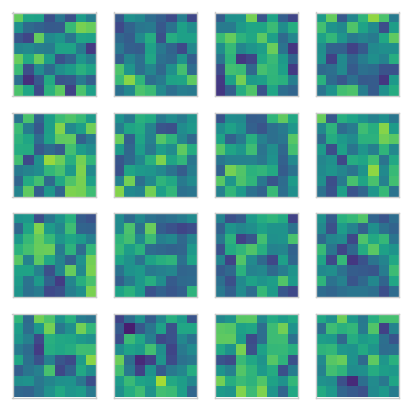

In [302]:
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
x = grab(torch_x)
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(x[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

slope 1 linear regression S = S_eff + -6.9038


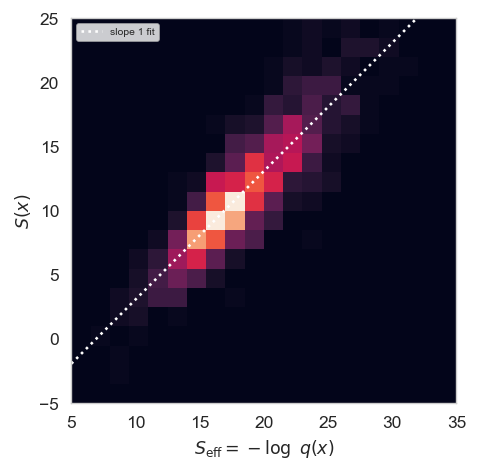

In [303]:
S_eff = -grab(torch_logq)
S = grab(phi4_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[5, 35], [-5, 25]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(5, 35, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()

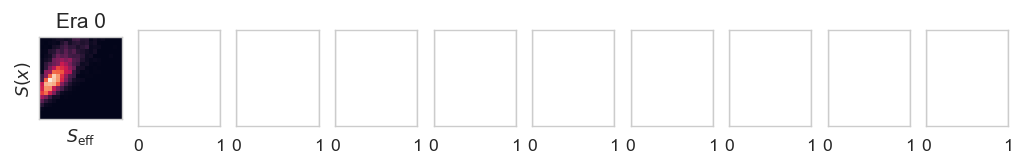

In [304]:
if not use_pretrained:
    fig, axes = plt.subplots(1, 10, dpi=125, sharey=True, figsize=(10, 1))
    logq_hist = np.array(history['logq']).reshape(N_era, -1)[::N_era//10]
    logp_hist = np.array(history['logp']).reshape(N_era, -1)[::N_era//10]
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
        ax.hist2d(-logq, -logp, bins=20, range=[[5, 35], [-5, 25]])
        if i == 0:
            ax.set_ylabel(r'$S(x)$')
        ax.set_xlabel(r'$S_{\mathrm{eff}}$')
        ax.set_title(f'Era {i * (N_era//10)}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        plt.show()

In [305]:
def serial_sample_generator(model, action, batch_size, N_samples):
    layers, prior = model['layers'], model['prior']
    layers.eval()
    x, logq, logp = None, None, None
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # we're out of samples to propose, generate a new batch
            x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
            logp = -action(x)
        yield x[batch_i], logq[batch_i], logp[batch_i]

In [306]:
def make_mcmc_ensemble(model, action, batch_size, N_samples):

    history = {
    'x' : [],
    'logq' : [],
    'logp' : [],
    'accepted' : []
    }
    # build Markov chain
    sample_gen = serial_sample_generator(model, action, batch_size, N_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # always accept first proposal, Markov chain must start somewhere
            accepted = True
        else:
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = min(1, p_accept)
            draw = torch.rand(1) # ~ [0,1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
    return history

In [307]:
ensemble_size = 8192
phi4_ens = make_mcmc_ensemble(model, phi4_action, 64, ensemble_size)
print("Accept rate:", np.mean(phi4_ens['accepted']))

Accept rate: 0.14599609375


In [308]:
n_therm = 512
cfgs = np.stack(list(map(grab, phi4_ens['x'])), axis=0)[n_therm:]
C = 0
for x in range(L):
    for y in range(L):
        C = C + cfgs*np.roll(cfgs, (-x, -y), axis=(1,2))
X = np.mean(C, axis=(1,2))
def bootstrap(x, *, Nboot, binsize):
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for i in range(Nboot):
        boots.append(np.mean(x[np.random.randint(len(x), size=len(x))], axis=(0,1)))
    return np.mean(boots), np.std(boots)
X_mean, X_err = bootstrap(X, Nboot=100, binsize=4)
print(f'Two-point susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
print(f'... vs HMC estimate = 0.75 +/- 0.01')

Two-point susceptibility = 0.66 +/- 0.02
... vs HMC estimate = 0.75 +/- 0.01


In [309]:
L = 8
lattice_shape = (L,L)
link_shape = (2,L,L)
# some arbitrary configurations
u1_ex1 = 2*np.pi*np.random.random(size=link_shape).astype(float_dtype)
u1_ex2 = 2*np.pi*np.random.random(size=link_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((u1_ex1, u1_ex2), axis=0)).to(torch_device)

In [310]:
def compute_u1_plaq(links, mu, nu):
    """Compute U(1) plaquettes in the (mu,nu) plane given 'links' = arg(U)"""
    return (links[:,mu] + torch.roll(links[:,nu], -1, mu+1)
        - torch.roll(links[:,mu], -1, nu+1) - links[:,nu])

In [311]:
class U1GaugeAction:
    def __init__(self, beta):
        self.beta = beta
    def __call__(self, cfgs):
        Nd = cfgs.shape[1]
        action_density = 0
        for mu in range(Nd):
            for nu in range(mu+1,Nd):
                action_density = action_density + torch.cos(
                    compute_u1_plaq(cfgs, mu, nu))
        return -self.beta * torch.sum(action_density, dim=tuple(range(1,Nd+1)))
print(U1GaugeAction(beta=1.0)(cfgs))

tensor([2.2219, 1.9865])


In [312]:
beta = 1
u1_action = U1GaugeAction(beta)

In [313]:
def gauge_transform(links, alpha):
    for mu in range(len(links.shape[2:])):
        links[:,mu] = alpha + links[:,mu] - torch.roll(alpha, -1, mu+1)
    return links
def random_gauge_transform(x):
    Nconf, VolShape = x.shape[0], x.shape[2:]
    return gauge_transform(x, 2*np.pi*torch.rand((Nconf,) + VolShape))
# action is invariant
cfgs_transformed = random_gauge_transform(cfgs)
print(u1_action(cfgs), 'vs', u1_action(cfgs_transformed))
assert np.allclose(grab(u1_action(cfgs)), grab(u1_action(cfgs_transformed))), \
    'gauge transform should be a symmetry of the action'

tensor([2.2219, 1.9865]) vs tensor([2.2219, 1.9865])


In [314]:
def topo_charge(x):
    P01 = torch_wrap(compute_u1_plaq(x, mu=0, nu=1))
    axes = tuple(range(1, len(P01.shape)))
    return torch.sum(P01, dim=axes) / (2*np.pi)
with np.printoptions(suppress=True):
    print(f'cfg topological charges = {grab(topo_charge(cfgs))}')
Q = grab(topo_charge(cfgs))
assert np.allclose(Q, np.around(Q), atol=1e-6), 'topological charge must be an integer'


cfg topological charges = [ 1.0000002  -0.99999994]


In [315]:
class MultivariateUniform(torch.nn.Module):
    """Uniformly draw samples from [a,b]"""
    def __init__(self, a, b):
        super().__init__()
        self.dist = torch.distributions.uniform.Uniform(a, b)
    def log_prob(self, x):
        axes = range(1, len(x.shape))
        return torch.sum(self.dist.log_prob(x), dim=tuple(axes))
    def sample_n(self, batch_size):
        return self.dist.sample((batch_size,))

In [316]:
prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))
z = prior.sample_n(17)
print(f'z.shape = {z.shape}')
print(f'log r(z) = {grab(prior.log_prob(z))}')

z.shape = torch.Size([17, 2, 8, 8])
log r(z) = [-235.24826 -235.24826 -235.24826 -235.24826 -235.24826 -235.24826
 -235.24826 -235.24826 -235.24826 -235.24826 -235.24826 -235.24826
 -235.24826 -235.24826 -235.24826 -235.24826 -235.24826]


In [317]:
class GaugeEquivCouplingLayer(torch.nn.Module):
    """U(1) gauge equiv coupling layer defined by 'plaq_coupling' acting on plaquettes."""
    def __init__(self, *, lattice_shape, mask_mu, mask_off, plaq_coupling):
        super().__init__()
        link_mask_shape = (len(lattice_shape),) + lattice_shape
        self.active_mask = make_2d_link_active_stripes(link_mask_shape, mask_mu, mask_off)
        self.plaq_coupling = plaq_coupling
    def forward(self, x):
        plaq = compute_u1_plaq(x, mu=0, nu=1)
        new_plaq, logJ = self.plaq_coupling(plaq)
        delta_plaq = new_plaq - plaq
        delta_links = torch.stack((delta_plaq, -delta_plaq), dim=1) # signs for U vs Udagger
        fx = self.active_mask * torch_mod(delta_links + x) + (1-self.active_mask) * x
        return fx, logJ
    def reverse(self, fx):
        new_plaq = compute_u1_plaq(fx, mu=0, nu=1)
        plaq, logJ = self.plaq_coupling.reverse(new_plaq)
        delta_plaq = plaq - new_plaq
        delta_links = torch.stack((delta_plaq, -delta_plaq), dim=1) # signs for U vs Udagger
        x = self.active_mask * torch_mod(delta_links + fx) + (1-self.active_mask) * fx
        return x, logJ

In [318]:
def make_2d_link_active_stripes(shape, mu, off):
    """
    Stripes mask looks like in the 'mu' channel (mu-oriented links)::

        1 0 0 0 1 0 0 0 1 0 0
        1 0 0 0 1 0 0 0 1 0 0
        1 0 0 0 1 0 0 0 1 0 0
        1 0 0 0 1 0 0 0 1 0 0

    where vertical is the 'mu' direction, and the pattern is offset in the nu
    direction by 'off' (mod 4). The other channel is identically 0.
    """
    assert len(shape) == 2+1, 'need to pass shape suitable for 2D gauge theory'
    assert shape[0] == len(shape[1:]), 'first dim of shape must be Nd'
    assert mu in (0,1), 'mu must be 0 or 1'
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[mu,:,0::4] = 1
    elif mu == 1:
        mask[mu,0::4] = 1
    nu = 1-mu
    mask = np.roll(mask, off, axis=nu+1)
    return torch.from_numpy(mask.astype(float_dtype)).to(torch_device)

In [319]:
def make_single_stripes(shape, mu, off):
    """

        1 0 0 0 1 0 0 0 1 0 0
        1 0 0 0 1 0 0 0 1 0 0
        1 0 0 0 1 0 0 0 1 0 0
        1 0 0 0 1 0 0 0 1 0 0

    where vertical is the 'mu' direction. Vector of 1 is repeated every 4.
    The pattern is offset in perpendicular to the 'mu' direction by 'off' (mod 4).
    """
    assert len(shape) == 2, 'need to pass 2D shape'
    assert mu in (0,1), 'mu must be 0 or 1'
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[:,0::4] = 1
    elif mu == 1:
        mask[0::4] = 1
    mask = np.roll(mask, off, axis=1-mu)
    return torch.from_numpy(mask).to(torch_device)

In [320]:
def make_double_stripes(shape, mu, off):
    """
    Double stripes mask looks like::

        1 1 0 0 1 1 0 0
        1 1 0 0 1 1 0 0
        1 1 0 0 1 1 0 0
        1 1 0 0 1 1 0 0

    where vertical is the 'mu' direction. The pattern is offset in perpendicular
    to the mu direction by 'off' (mod 4).
    """
    assert len(shape) == 2, 'need to pass 2D shape'
    assert mu in (0,1), 'mu must be 0 or 1'
    mask = np.zeros(shape).astype(np.uint8)
    if mu == 0:
        mask[:,0::4] = 1
        mask[:,1::4] = 1
    elif mu == 1:
        mask[0::4] = 1
        mask[1::4] = 1
    mask = np.roll(mask, off, axis=1-mu)
    return torch.from_numpy(mask).to(torch_device)

In [321]:
def make_plaq_masks(mask_shape, mask_mu, mask_off):
    mask = {}
    mask['frozen'] = make_double_stripes(mask_shape, mask_mu, mask_off+1)
    mask['active'] = make_single_stripes(mask_shape, mask_mu, mask_off)
    mask['passive'] = 1 - mask['frozen'] - mask['active']
    return mask
# For example
_test_plaq_masks = make_plaq_masks((8,8), 0, mask_off=1)
print('Frozen (fed into NNs)')
print(_test_plaq_masks['frozen'])
print('Active (driving the link update)')
print(_test_plaq_masks['active'])
print('Passive (updated as a result of link update)')
print(_test_plaq_masks['passive'])

Frozen (fed into NNs)
tensor([[0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1],
        [0, 0, 1, 1, 0, 0, 1, 1]], dtype=torch.uint8)
Active (driving the link update)
tensor([[0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0]], dtype=torch.uint8)
Passive (updated as a result of link update)
tensor([[1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0]], dtype=torch.uint8)


In [322]:
def tan_transform(x, s):
    return torch_mod(2*torch.atan(torch.exp(s)*torch.tan(x/2)))
def tan_transform_logJ(x, s):
    return -torch.log(torch.exp(-s)*torch.cos(x/2)**2 + torch.exp(s)*torch.sin(x/2)**2)

In [323]:
def mixture_tan_transform(x, s):
    assert len(x.shape) == len(s.shape), \
        f'Dimension mismatch between x and s {x.shape} vs {s.shape}'
    return torch.mean(tan_transform(x, s), dim=1, keepdim=True)
def mixture_tan_transform_logJ(x, s):
    assert len(x.shape) == len(s.shape), \
        f'Dimension mismatch between x and s {x.shape} vs {s.shape}'
    return torch.logsumexp(tan_transform_logJ(x, s), dim=1) - np.log(s.shape[1])

In [324]:
def invert_transform_bisect(y, *, f, tol, max_iter, a=0, b=2*np.pi):
    min_x = a*torch.ones_like(y)
    max_x = b*torch.ones_like(y)
    min_val = f(min_x)
    max_val = f(max_x)
    with torch.no_grad():
        for i in range(max_iter):
            mid_x = (min_x + max_x) / 2
            mid_val = f(mid_x)
            greater_mask = (y > mid_val).int()
            greater_mask = greater_mask.float()
            err = torch.max(torch.abs(y - mid_val))
            if err < tol: return mid_x
            if torch.all((mid_x == min_x) + (mid_x == max_x)):
                print('WARNING: Reached floating point precision before tolerance '
                    f'(iter {i}, err {err})')
                return mid_x
            min_x = greater_mask*mid_x + (1-greater_mask)*min_x
            min_val = greater_mask*mid_val + (1-greater_mask)*min_val
            max_x = (1-greater_mask)*mid_x + greater_mask*max_x
            max_val = (1-greater_mask)*mid_val + greater_mask*max_val
        print(f'WARNING: Did not converge to tol {tol} in {max_iter} iters! Error was {err}')
        return mid_x

In [325]:
def stack_cos_sin(x):
    return torch.stack((torch.cos(x), torch.sin(x)), dim=1)

In [326]:
class NCPPlaqCouplingLayer(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_mu, mask_off,
        inv_prec=1e-6, inv_max_iter=1000):
        super().__init__()
        assert len(mask_shape) == 2, (
            f'NCPPlaqCouplingLayer is implemented only in 2D, '
            f'mask shape {mask_shape} is invalid')
        self.mask = make_plaq_masks(mask_shape, mask_mu, mask_off)
        self.net = net
        self.inv_prec = inv_prec
        self.inv_max_iter = inv_max_iter
    def forward(self, x):
        x2 = self.mask['frozen'] * x
        net_out = self.net(stack_cos_sin(x2))
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels'
        s, t = net_out[:,:-1], net_out[:,-1]
        x1 = self.mask['active'] * x
        x1 = x1.unsqueeze(1)
        local_logJ = self.mask['active'] * mixture_tan_transform_logJ(x1, s)
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = torch.sum(local_logJ, dim=axes)
        fx1 = self.mask['active'] * mixture_tan_transform(x1, s).squeeze(1)
        fx = (
            self.mask['active'] * torch_mod(fx1 + t) +
            self.mask['passive'] * x +
            self.mask['frozen'] * x)
        return fx, logJ
    def reverse(self, fx):
        fx2 = self.mask['frozen'] * fx
        net_out = self.net(stack_cos_sin(fx2))
        assert net_out.shape[1] >= 2, 'CNN must output n_mix (s_i) + 1 (t) channels'
        s, t = net_out[:,:-1], net_out[:,-1]
        x1 = torch_mod(self.mask['active'] * (fx - t).unsqueeze(1))
        transform = lambda x: self.mask['active'] * mixture_tan_transform(x, s)
        x1 = invert_transform_bisect(
            x1, f=transform, tol=self.inv_prec, max_iter=self.inv_max_iter)
        local_logJ = self.mask['active'] * mixture_tan_transform_logJ(x1, s)
        axes = tuple(range(1, len(local_logJ.shape)))
        logJ = -torch.sum(local_logJ, dim=axes)
        x1 = x1.squeeze(1)
        x = (
            self.mask['active'] * x1 +
            self.mask['passive'] * fx +
            self.mask['frozen'] * fx2)
        return x, logJ

In [327]:
def make_u1_equiv_layers(*, n_layers, n_mixture_comps, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
        # periodically loop through all arrangements of maskings
        mu = i % 2
        off = (i//2) % 4
        in_channels = 2 # x - > (cos(x), sin(x))
        out_channels = n_mixture_comps + 1 # for mixture s and t, respectively
        net = make_conv_net(in_channels=in_channels, out_channels=out_channels,
            hidden_sizes=hidden_sizes, kernel_size=kernel_size,
            use_final_tanh=False)
        plaq_coupling = NCPPlaqCouplingLayer(
            net, mask_shape=lattice_shape, mask_mu=mu, mask_off=off)
        link_coupling = GaugeEquivCouplingLayer(
            lattice_shape=lattice_shape, mask_mu=mu, mask_off=off,
            plaq_coupling=plaq_coupling)
        layers.append(link_coupling)
    return torch.nn.ModuleList(layers)

In [328]:
use_pretrained = False

In [329]:
# Theory
L = 8
lattice_shape = (L,L)
link_shape = (2,L,L)
beta = 2.0
u1_action = U1GaugeAction(beta)
# Model
prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))
n_layers = 16
n_s_nets = 2
hidden_sizes = [8,8]
kernel_size = 3
layers = make_u1_equiv_layers(lattice_shape=lattice_shape, n_layers=n_layers, n_mixture_comps=n_s_nets,hidden_sizes=hidden_sizes, kernel_size=kernel_size)
set_weights(layers)
model = {'layers': layers, 'prior': prior}
# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

In [330]:
if use_pretrained:
    print('Loading pre-trained model')
    u1_trained_weights = torch.load(io.BytesIO(base64.b64decode(b"""
<snipped base64 blob>
    """.strip())), map_location=torch.device('cpu'))
    model['layers'].load_state_dict(u1_trained_weights)
    if torch_device == 'cuda':
        model['layers'].cuda()
else:
    print('Skipping pre-trained model')

Skipping pre-trained model


In [331]:
N_era = 10
N_epoch = 100
batch_size = 64
print_freq = N_epoch # epochs
plot_freq = 1 # epochs
history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

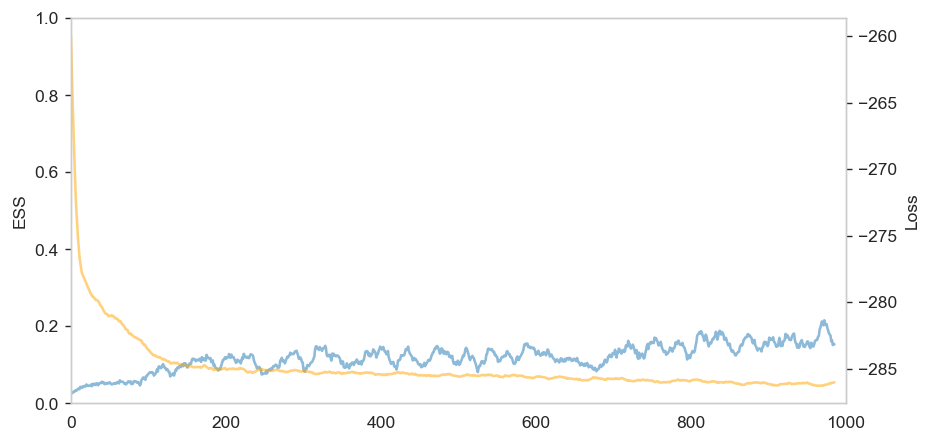

== Era 0 | Epoch 0 metrics ==
	loss -241.236
	logp 6.5677
	logq -234.668
	ess 0.0156842
== Era 1 | Epoch 0 metrics ==
	loss -277.997
	logp 67.8844
	logq -210.113
	ess 0.0468931
== Era 2 | Epoch 0 metrics ==
	loss -284.543
	logp 80.9915
	logq -203.552
	ess 0.0955929
== Era 3 | Epoch 0 metrics ==
	loss -285.127
	logp 82.3304
	logq -202.797
	ess 0.110294
== Era 4 | Epoch 0 metrics ==
	loss -285.306
	logp 82.8142
	logq -202.492
	ess 0.114781
== Era 5 | Epoch 0 metrics ==
	loss -285.437
	logp 83.0746
	logq -202.362
	ess 0.124421
== Era 6 | Epoch 0 metrics ==
	loss -285.548
	logp 83.2982
	logq -202.25
	ess 0.119927
== Era 7 | Epoch 0 metrics ==
	loss -285.726
	logp 83.6513
	logq -202.074
	ess 0.112118
== Era 8 | Epoch 0 metrics ==
	loss -285.893
	logp 83.8366
	logq -202.056
	ess 0.142011
== Era 9 | Epoch 0 metrics ==
	loss -286.014
	logp 84.1624
	logq -201.852
	ess 0.155108


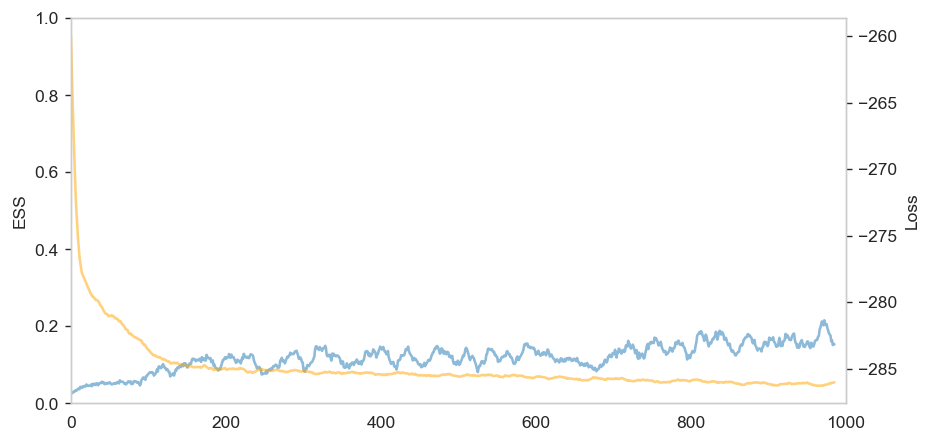

In [332]:
if not use_pretrained:
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
    live_plot = init_live_plot()
    for era in range(N_era):
        for epoch in range(N_epoch):
            train_step(model, u1_action, calc_dkl, optimizer, history)
            if epoch % print_freq == 0:
                print_metrics(history, avg_last_N_epochs=print_freq)
            if epoch % plot_freq == 0:
                update_plots(history, **live_plot)
else:
    print('Skipping training')

In [333]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8'))
print('===')

Model weights blob:
===
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYHAAAADAucGxhcV9jb3VwbGluZy5uZXQuMC53ZWlnaHRxAmN0b3JjaC5fdXRpbHMKX3JlYnVpbGRfdGVuc29yX3YyCnEDKChYBwAAAHN0b3JhZ2VxBGN0b3JjaApGbG9hdFN0b3JhZ2UKcQVYAQAAADBxBlgGAAAAY3VkYTowcQdLkHRxCFFLAChLCEsCSwNLA3RxCShLEksJSwNLAXRxColoAClScQt0cQxScQ1YGgAAADAucGxhcV9jb3VwbGluZy5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPWAYAAABjdWRhOjBxEEsIdHERUUsASwiFcRJLAYVxE4loAClScRR0cRVScRZYHAAAADAucGxhcV9jb3VwbGluZy5uZXQuMi53ZWlnaHRxF2gDKChoBGgFWAEAAAAycRhYBgAAAGN1ZGE6MHEZTUACdHEaUUsAKEsISwhLA0sDdHEbKEtISwlLA0sBdHEciWgAKVJxHXRxHlJxH1gaAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC4yLmJpYXNxIGgDKChoBGgFWAEAAAAzcSFYBgAAAGN1ZGE6MHEiSwh0cSNRSwBLCIVxJEsBhXEliWgAKVJxJnRxJ1JxKFgcAAAAMC5wbGFxX2NvdXBsaW5nLm5ldC40LndlaWdodHEpaAMoKGgEaAVYAQAAADRxKlgGAAAAY3VkYTowcStL2HRxLFFLAChLA0sISwNLA3RxLShLSEsJSwNLAXRxLoloAClScS90cTBScTFYGgAAADAucGxhcV9jb3VwbGluZy5uZXQuNC5iaWFzcTJoAygoaARoBVgBAAAANXEzWAYAAABj

slope 1 linear regression S = S_eff + -286.0288


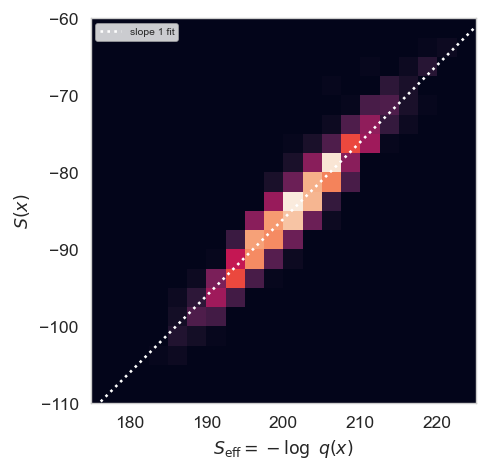

In [334]:
layers, prior = model['layers'], model['prior']
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
S_eff = -grab(torch_logq)
S = grab(u1_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[175, 225], [-110, -60]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(175, 225, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()

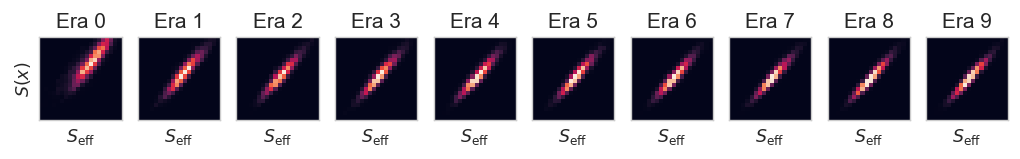

In [335]:
if not use_pretrained:
    fig, axes = plt.subplots(1, 10, dpi=125, sharey=True, figsize=(10, 1))
    logq_hist = np.array(history['logq']).reshape(N_era, -1)[::N_era//10]
    logp_hist = np.array(history['logp']).reshape(N_era, -1)[::N_era//10]
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logp_hist)):
        ax.hist2d(-logq, -logp, bins=20, range=[[175, 225], [-110, -60]])
        if i == 0:
            ax.set_ylabel(r'$S(x)$')
        ax.set_xlabel(r'$S_{\mathrm{eff}}$')
        ax.set_title(f'Era {i * (N_era//10)}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.show()
else:
    print('Skipping plot because use_pretrained == True')

In [336]:
ensemble_size = 8192
u1_ens = make_mcmc_ensemble(model, u1_action, 64, ensemble_size)
print("Accept rate:", np.mean(u1_ens['accepted']))

Accept rate: 0.16650390625


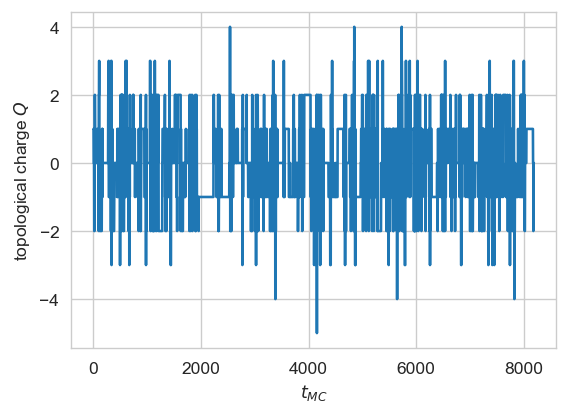

In [337]:
Q = grab(topo_charge(torch.stack(u1_ens['x'], axis=0)))
plt.figure(figsize=(5,3.5), dpi=125)
plt.plot(Q)
plt.xlabel(r'$t_{MC}$')
plt.ylabel(r'topological charge $Q$')
plt.show()

In [338]:
X_mean, X_err = bootstrap(Q**2, Nboot=100, binsize=16)
print(f'Topological susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
print(f'... vs HMC estimate = 1.23 +/- 0.02')

Topological susceptibility = 1.27 +/- 0.05
... vs HMC estimate = 1.23 +/- 0.02
